In [1]:
import os,shutil
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt

# Helpers
from SimEx.Utilities.Units import meter, electronvolt, joule, radian

# PMI
from SimEx.Calculators.XMDYNDemoPhotonMatterInteractor import XMDYNDemoPhotonMatterInteractor

# Simple Beam Parameters
from SimEx.Parameters.PhotonBeamParameters import PhotonBeamParameters

# Diffraction
from SimEx.Parameters.DetectorGeometry import DetectorGeometry, DetectorPanel
from SimEx.Parameters.SingFELPhotonDiffractorParameters import SingFELPhotonDiffractorParameters
from SimEx.Calculators.SingFELPhotonDiffractor import SingFELPhotonDiffractor

# Analysis
from SimEx.Analysis.XFELPhotonAnalysis import XFELPhotonAnalysis
from SimEx.Analysis.DiffractionAnalysis import DiffractionAnalysis

import matplotlib.colors as colors

initializing ocelot...



In [2]:
def cleanUp(out_path):
    dirs_to_remove=[out_path]
    files_to_remove=[out_path+'.h5']

    for d in dirs_to_remove:
        if os.path.isdir(d):
            shutil.rmtree(d)
    for f in files_to_remove:
        if os.path.isfile(f):
            os.remove(f)

In [3]:
# Beam setup
beam = PhotonBeamParameters(
    photon_energy=4.96e3 * electronvolt,
    beam_diameter_fwhm=1.0e-6 * meter,
    pulse_energy=1.0e-3 * joule * 3900,
)

# Detector setup
p0 = DetectorPanel(ranges={
    'fast_scan_min': 0,
    'fast_scan_max': 99,
    'slow_scan_min': 0,
    'slow_scan_max': 99
},
                   pixel_size=440e-6 * meter,
                   photon_response=1.0,
                   distance_from_interaction_plane=0.13 * meter,
                   corners={
                       'x': -49.5,
                       'y': -49.5
                   },
                   fast_scan_xyz='1.0x',
                   slow_scan_xyz='1.0y')

detector_geometry = DetectorGeometry(panels=[p0])

In [4]:
detector_geometry.serialize('diffr_100x100_50k_unifrom.geom')

In [4]:
diffraction_parameters = SingFELPhotonDiffractorParameters(
                                               uniform_rotation=True,
                                               slice_interval=1,
                                               number_of_slices=1,
                                               number_of_diffraction_patterns=1,
                                               detector_geometry=detector_geometry,
                                               beam_parameters = beam,
                                               forced_mpi_command='mpirun -np 36')

In [5]:
out_path = "diffr_test"

In [6]:
cleanUp(out_path)

In [7]:
diffractor = SingFELPhotonDiffractor(parameters=diffraction_parameters,
                                     input_path='3IYF.pdb',
                                     output_path=out_path)

In [8]:
from timeit import default_timer as timer
start = timer()

diffractor.backengine()

end = timer()
print(end - start,'s') # Time in seconds

36.449515391141176 s


In [9]:
# Link the .h5 output generated from mpirun together
diffractor.saveH5()

In [10]:
# H5Glance('diffr.h5')

<HDF5 group "/data" (1 members)>
109.37280567090299 29021.174020735456 3.5764600190914947e-06


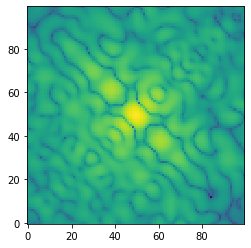

In [11]:
with h5py.File(out_path+'.h5','r') as f:
    print (f['data'])
    for i,iteration in enumerate(f['data']):
        if i < 4:
            diffr = f['data'][iteration]['diffr'][0]
            plt.figure()
            plt.imshow(diffr,norm=colors.LogNorm(vmin=diffr.min(), vmax=diffr.max()),origin='lower')
            print (diffr.mean(),diffr.max(),diffr.min())